# Calculate fluxes from EDGE Black CO2 data

All the data here are on the Google drive - change the path to your local one
if you want to run this.

In [1]:
import sys
sys.path.append('/home/greg/GitHub/')
import numpy as np
import pandas as pd
import sawyer.dtools as sto
import ecoflux.soil_gas_profile as sp
import get_edge as ge

/home/greg/GitHub/sawyer/config.py:59: UserWarning: 
sawyer_config directory not in current or parent directory.
Project configs not found!
  ' or parent directory.\nProject configs not found!' + tcol.ENDC)


Would you like to select a project directory? (Y/n)
 n


No directory given, continuing...
Unspecified project, no sawyer configs or paths available


In [2]:
# Path to datalogger files
dpath = '/home/greg/GD_gregmaurer/Sev Soil Respiration Data/EDGE_Black_SoilSensorDat/'

In [3]:
# Read in a file with data on the soil profiles
soildf = pd.read_csv(
        '/home/greg/GD_gregmaurer/Sev Soil Respiration Data/sev_soil_profiles.csv',
        skiprows=3)

In [4]:
# Get the datalogger data (see get_edge.py, which was imported above)
eb = ge.black_soil(dpath)

Parsing /home/greg/GD_gregmaurer/Sev Soil Respiration Data/EDGE_Black_SoilSensorDat/EDGE_Black_CR1000_1_co2.dat
Parsing /home/greg/GD_gregmaurer/Sev Soil Respiration Data/EDGE_Black_SoilSensorDat/EDGE_Black_CR1000_2_co2.dat
Parsing /home/greg/GD_gregmaurer/Sev Soil Respiration Data/EDGE_Black_SoilSensorDat/EDGE_Black_CR1000_1_vwc.dat
Parsing /home/greg/GD_gregmaurer/Sev Soil Respiration Data/EDGE_Black_SoilSensorDat/EDGE_Black_CR1000_2_vwc.dat
Parsing /home/greg/GD_gregmaurer/Sev Soil Respiration Data/EDGE_Black_SoilSensorDat/EDGE_Black_CR1000_1_temp.dat
Parsing /home/greg/GD_gregmaurer/Sev Soil Respiration Data/EDGE_Black_SoilSensorDat/EDGE_Black_CR1000_2_temp.dat
Parsing /home/greg/GD_gregmaurer/Sev Soil Respiration Data/EDGE_Black_SoilSensorDat/EDGE_Black_CR1000_2_met.dat


In [5]:

# Create a CO2 sensor configuration dictionary (uses sawyer)
co2conf = sto.var_h_v_dict2(eb.columns, 'CO2', horiz=0, vert=4)
co2conf

{'P17CON': ['5', '10', '20', 'AG25'],
 'P18CON': ['5', '10', '20', 'AG25'],
 'P19ESR': ['5', '10', '20'],
 'P20DRT': ['5', '10', '20'],
 'P22ESR': ['5', '10', '20'],
 'P13DRT': ['5', '10', '20'],
 'P23CON': ['5', '10', '20'],
 'P16ESR': ['5', '10', '20'],
 'P25DRT': ['5', '10', '20']}

In [6]:
# Use the mean of the 2 surface sensors as our surface measurement
surf = [s for s in eb.columns if 'CO2' in s and 'AG25' in s]
eb['SURF_CO2'] = eb[surf].mean(axis=1)

# Write the joined Edge Black data to file
eb.to_csv(dpath + '/EdgeBlack_join_DRAFT.csv')

In [7]:
# Calculate the fluxes
# This section is a bit hairy. Calculation of fluxes mainly happens in 
# the "ecoflux" module (on Greg's GitHub). The loop below goes through
# each profile in the Edge Black dataset, creates matrices of CO2, VWC,
# Tsoil, soil texture, etc and then sends them to an ecoflux function.
# Calculated fluxes are then joined and written out into a file.

#%pdb
siteid = 'edgeblack'
soilprofile='1'
particled=2.65

for i, co2prof in enumerate(sorted(co2conf.keys())):
    # Get profile number and CO2 sensor depths
    #sensor, profile = co2prof.split('_')
    sensor='CO2'
    profile=co2prof
    co2depths = co2conf[co2prof]
    if 'AG25' in co2depths: co2depths.remove('AG25')
    co2depths = sorted([int(l) for l in co2depths])
    # Get porosity sandsilt and z_vals (eventually this may happen by
    # profile when all samples are measured)
    soil = soildf.query("siteid_1=='" + siteid + 
            "' and profile==" + soilprofile)
    # Reduce replicates to their mean
    gby = soil.groupby(['siteid_1', 'profile', 'horizon'])
    soil = gby.mean()# only needed if replicate masurements
    # Get boolean array for soil depths with sensor placements
    sensormatch = pd.Series(False, index=soil.index)
    #stop()
    for d in range(len(co2depths)):
        test = np.logical_and(co2depths[d] > soil.depth_top,
                co2depths[d] < soil.depth_bottom)
        sensormatch = sensormatch | test

    # Now get soil depth/textural data for each sensor cluster
    poros = 1 - (soil[sensormatch].bulk_d_est/particled)
    sandsilt = soil[sensormatch].ss/100
    #stop()
    z_vals = pd.Series([c/100 for c in co2depths],
                       index=soil[sensormatch].index)

    # Get column names for CO2, Tsoil, and VWC vectors and sort to proper order
    C_cols = [s for s in eb.columns if profile in s and 'CO2' in s and 'AG25' not in s]
    C_cols = sorted(C_cols, key=lambda x: int(x.split('_')[4]))
    Ts_cols = [s for s in eb.columns if profile in s and 'SOILTEMP' in s]
    Ts_cols = sorted(Ts_cols, key=lambda x: int(x.split('_')[4]))
    Ts_cols = Ts_cols + [Ts_cols[1]]
    VWC_cols = [s for s in eb.columns if profile in s and 'VWC' in s]
    VWC_cols = sorted(VWC_cols, key=lambda x: int(x.split('_')[4]))
    VWC_cols = VWC_cols + [VWC_cols[1]]
    # Concatenate surface CO2 and 3 in-soil sensors into a 2d vector
    Cd = np.column_stack([eb['SURF_CO2'].values, eb[C_cols].values])
    # Make 2d vector of Tsoil
    Tsd = eb[Ts_cols].values
    # Make 2d vector of VWC data
    # The rolling mean helps with temperature sensitivity
    VWCd = eb[VWC_cols].rolling(window=144, center=True).mean().values
    # Calculate the fluxes (old function, ignore)
    #f_mold99, p, d_mold99 = sp.gradient_flux_prod(Cd,Tsd,VWCd,
    #        df['BP_hPa'].values,poros,sandsilt,z_vals=[0.05,0.25,0.5,1.25],
    #        makeplots=True)
    # Calculate fluxes with revised function
    # Default Ds model is Moldrup9, others available
    f_mold99, d_mold99 = sp.diff_profile_to_flux(Cd, Tsd, VWCd,
            poros,sandsilt,z_vals,eb['bPressure_Avg'].values,
            makeplots=True)
    # Rename returned columns then put in a dataframe for writing out
    fluxcols = ['CO2flux_{0}_surf', 'CO2flux_{0}_d1', 'CO2flux_{0}_d2',
                'CO2flux_{0}_dTot']
    fluxcols = [s.format(profile) for s in fluxcols]
    fluxtmp = pd.DataFrame(f_mold99, columns=fluxcols, index=eb.index)
    
    if i < 1:
        fluxout = fluxtmp
    else:
        fluxout = pd.concat([fluxout, fluxtmp], axis=1)

Calculating flux for boundary and 3 depths.
Boundary VWC, Tsoil, and soil texture derived from shallowest measurements
Calculating flux for boundary and 3 depths.
Boundary VWC, Tsoil, and soil texture derived from shallowest measurements
Calculating flux for boundary and 3 depths.
Boundary VWC, Tsoil, and soil texture derived from shallowest measurements
Calculating flux for boundary and 3 depths.
Boundary VWC, Tsoil, and soil texture derived from shallowest measurements
Calculating flux for boundary and 3 depths.
Boundary VWC, Tsoil, and soil texture derived from shallowest measurements
Calculating flux for boundary and 3 depths.
Boundary VWC, Tsoil, and soil texture derived from shallowest measurements
Calculating flux for boundary and 3 depths.
Boundary VWC, Tsoil, and soil texture derived from shallowest measurements
Calculating flux for boundary and 3 depths.
Boundary VWC, Tsoil, and soil texture derived from shallowest measurements
Calculating flux for boundary and 3 depths.
Boun

In [8]:
# Write to csv
fluxout.to_csv(dpath + '/EdgeBlack_fluxes_DRAFT.csv')

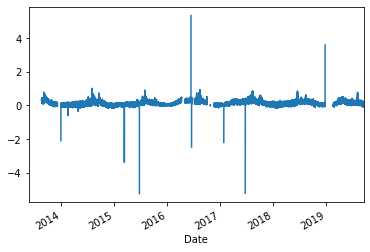

In [9]:
# Plot one of the surface fluxes - still a bit spiky
fluxout.CO2flux_P16ESR_surf.plot()